In [ ]:
!pip install pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 121.7 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import matplotlib.pyplot as plt
import os
import cv2

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [ ]:
n_epochs = 5   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 0    # Size of the train dataset
n_test = 0     # Size of the test dataset


In [ ]:

SAVE_PATH = "/content/drive/MyDrive/qcnn"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator
train_path="/content/drive/MyDrive/qcnn/train"
test_path="/content/drive/MyDrive/qcnn/test"
train_img=[]
train_lbl=[]
n_train=0
n_test=0

In [ ]:
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        n_train+=1
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        train_img.append(img_arr)
        train_lbl.append(0 if folder=='Covid' else (1 if folder=='Normal' else 2))
test_img=[]
test_lbl=[]
for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        n_test+=1
        image_path=sub_path+"/"+img
        #print('tp1',image_path)
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        test_img.append(img_arr)
        test_lbl.append(0 if folder=='Covid' else 1 if folder=='Normal' else 2)
train_images = np.array(train_img)
train_labels = np.array(train_lbl)
test_images = np.array(test_img)
test_labels = np.array(test_lbl)

In [ ]:
# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

In [ ]:
# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)
if 1==1:   #1 for pennylane simulator, any number for IBM QPU
    dev = qml.device("lightning.qubit", wires=4)
else:
    from qiskit_ibm_runtime import QiskitRuntimeService
    service = QiskitRuntimeService('ibm_quantum','8791a7c6af1662114ae85a2ccd7c6f7c82a9ecd9b71e7d95003b7743b6d5a1a18975ffbfc90a8cbb0429601eba88e1c4043bd0f6e96809c0f6875b0b7fe7852c')
    backend = service.least_busy(operational=True, simulator=False)
    print("Running on IBM QPU ",backend)
    dev = qml.device("qiskit.remote", wires=4, backend=backend)


In [ ]:
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

In [ ]:
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    n1=14
    n2=14
    n3=4
    out = np.zeros((n1, n2, n3))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, n1, 2):
        for k in range(0, n2, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)



Quantum pre-processing of train images:


<ipython-input-9-50febc1777f4>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[j // 2, k // 2, c] = q_results[c]



Quantum pre-processing of test images:


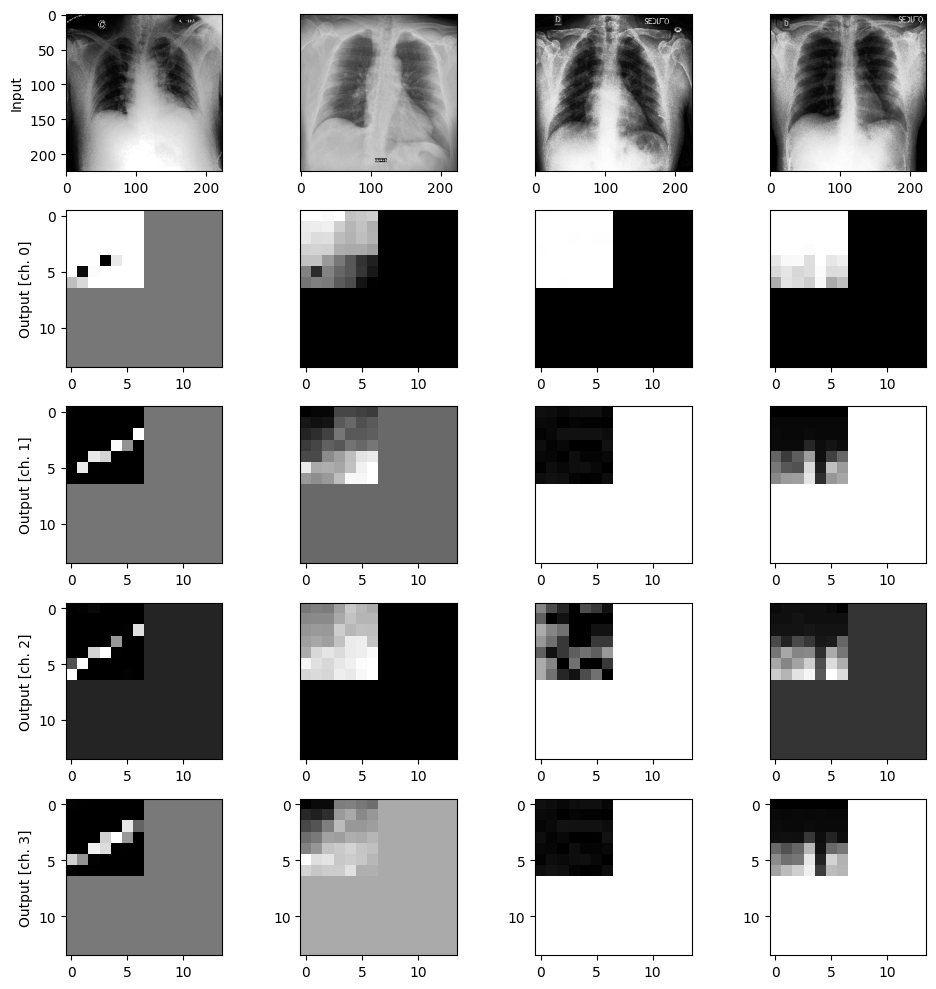

In [ ]:
# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
#plt.show()

In [ ]:
def MyQModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    num_filters = 8 #8
    filter_size = 4 #3
    pool_size = 3

    model = Sequential([
        Conv2D(num_filters, filter_size, input_shape=(14,14,4)),
        MaxPooling2D(pool_size=pool_size),
        Flatten(),
        Dense(4,activation='softmax'),
    ])

    model.compile(
        'adamax',
        loss='SparseCategoricalCrossentropy',
        metrics=['accuracy'],
    )
    #print(model.summary())
    return model


In [ ]:
def MyCModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    num_filters = 8 #8
    filter_size = 4 #3
    pool_size = 3

    model = Sequential([
        Conv2D(num_filters, filter_size, input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=pool_size),
        Flatten(),
        Dense(3,activation='softmax'),
    ])

    model.compile(
        'adamax',
        loss='SparseCategoricalCrossentropy',
        metrics=['accuracy'],
    )
    #print(model.summary())
    return model




In [ ]:
q_model = MyQModel()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
print(q_train_images.shape)


(135, 14, 14, 4)


In [ ]:
q_train_images = q_train_images.reshape((-1, 14, 14, 4))
q_test_images = q_test_images.reshape((-1, 14, 14, 4))


In [ ]:
print(q_train_images.shape)
print(q_train_images[0])


(135, 14, 14, 4)
[[[ 1.         -0.82079218 -0.10606591 -0.82054303]
  [ 1.         -0.82776721 -0.09820073 -0.82770439]
  [ 1.         -0.8346166  -0.08242685 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.834

In [ ]:
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/5
34/34 - 0s - 13ms/step - accuracy: 0.5481 - loss: 0.9389
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


34/34 - 0s - 9ms/step - accuracy: 0.6000 - loss: 0.9159
Epoch 3/5
34/34 - 0s - 9ms/step - accuracy: 0.5926 - loss: 0.8992
Epoch 4/5
34/34 - 1s - 19ms/step - accuracy: 0.6074 - loss: 0.8862
Epoch 5/5
34/34 - 0s - 9ms/step - accuracy: 0.6296 - loss: 0.8754


In [ ]:
c_model = MyCModel()

In [ ]:
print(train_images.shape)
print(train_images[0])


(135, 224, 224, 3, 1)
[[[[0.        ]
   [0.        ]
   [0.        ]]

  [[0.00784314]
   [0.00784314]
   [0.00784314]]

  [[0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.73333333]
   [0.73333333]
   [0.73333333]]

  [[0.71372549]
   [0.71372549]
   [0.71372549]]

  [[0.74901961]
   [0.74901961]
   [0.74901961]]]


 [[[0.        ]
   [0.        ]
   [0.        ]]

  [[0.00784314]
   [0.00784314]
   [0.00784314]]

  [[0.00392157]
   [0.00392157]
   [0.00392157]]

  ...

  [[0.76078431]
   [0.76078431]
   [0.76078431]]

  [[0.75294118]
   [0.75294118]
   [0.75294118]]

  [[0.75294118]
   [0.75294118]
   [0.75294118]]]


 [[[0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.8       ]
   [0.8       ]
   [0.8       ]]

  [[0.80392157]
   [0.80392157]
   [0.80392157]]

  [[0.78823529]
   [0.78823529]
   [0.78823529]]]


 ...


 [[[0.        ]
   [0.        ]
   [0.      

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/qcnn',
    image_size=(224, 224),
    batch_size=4,
    label_mode='int',  # or 'categorical' for one-hot
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/qcnn',
    image_size=(224, 224),
    batch_size=4,
    label_mode='int',
    validation_split=0.2,
    subset="validation",
    seed=123
)


Found 135 files belonging to 2 classes.
Using 108 files for training.
Found 135 files belonging to 2 classes.
Using 27 files for validation.


In [ ]:
c_history = c_model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9037 - loss: 46.1722 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


KeyError: 'val_accuracy'

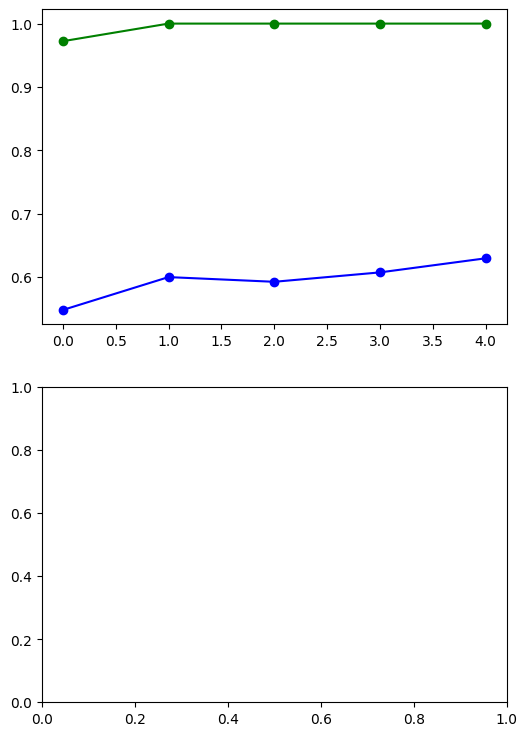

In [ ]:
import matplotlib.pyplot as plt

#plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["accuracy"], "-og", label="Without quantum layer")
ax2.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()
ax2.set_ylabel("Val Accuracy")
ax2.set_ylim([0, 1])
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()
